# Programming Exercise 4

In [4]:
import numpy as np

import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [5]:
def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    We implemented this function as copying entries from a CSR_matrix is seemingly much more expensive than we thought.
    To improve our runtime we use this method which we found online. 
    (Our other version worked too, but for n=100 it took around 5 minutes: A_schlange=sp.csr_matrix(np.array([[A[i,j] for j in indices]for i in indices])))
    """
    if not isinstance(mat, sp.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

In [6]:
def christmas_tree_mesh(k, tree_levels = 4):
    ## Generates a mesh of a Christmas tree domain
    ##       width of the base:   [-0.5 - 0.5*tree_levels, 0.5 + 0.5*tree_levels]
    ##       height of the tree:  [0., 2*tree_levels]
    
    ## Returns: nodes:          an array with the coordinates of every node, i.e. nodes[k] = [x_k, y_k]
    ##          elements:       an array of the elements, each of them represented by the indices (in nodes) of its 3 vertices
    ##          boundary_nodes: a list of the indices (in nodes) of those nodes in the boundary of the domain
    ##          boundary_edges: a list of boundary edges, each of them being a pair of node indices
    
    total_height = tree_levels * 2.
    
    xh = 1. / (2**k)
    yh = 2. * xh
    
    x_at_level = {}
    y_at_level = {}
    elements_at_level = {}
    boundary_nodes_at_level = {}
    boundary_edges_at_level = {}
    
    node_idx = 1
    last_boundary_node_left = 0
    last_boundary_node_right = 0
    
    for L in range(tree_levels):
        if L == 0:
            # Initialize with the top node
            x_at_level[L] = [0.]
            y_at_level[L] = [2.*tree_levels]
            boundary_nodes_at_level[L] = [0]
        else:
            boundary_nodes_at_level[L] = []
            
            # Initialize with the last 1 + L*2**k nodes from previous level
            q = 1 + L*2**k
            x_at_level[L] = x_at_level[L-1][-q:]
            y_at_level[L] = y_at_level[L-1][-q:]
        
        boundary_edges_at_level[L] = []
        
        for i in range(1, 2**k + 1):
            yi = total_height - L*2. - i*yh
            
            boundary_edges_at_level[L].append([node_idx, last_boundary_node_left])
            boundary_edges_at_level[L].append([node_idx+1, last_boundary_node_right])
            
            boundary_nodes_at_level[L].append(node_idx)
            boundary_nodes_at_level[L].append(node_idx+1)
            
            last_boundary_node_left = node_idx
            last_boundary_node_right = node_idx + 1
            
            for j in reversed(range(1, 1 + i + L * 2**(k-1))):
                y_at_level[L].append(yi)
                y_at_level[L].append(yi)
                
                x_at_level[L].append(-j * xh)
                x_at_level[L].append(j * xh)
                
                node_idx += 2
            
            y_at_level[L].append(yi)
            x_at_level[L].append(0.)
            node_idx += 1
        
        if L == (tree_levels - 1):
            # The last (2**k) * (L+2) - 1 are also boundary nodes
            q = (2**k) * (L+2) - 1
            
            for idx in range(node_idx - q, node_idx):
                boundary_nodes_at_level[L].append(idx)
                boundary_edges_at_level[L].append([idx, idx - 2])
                
            boundary_edges_at_level[L].append([node_idx - 1, node_idx - 2])
        else:
            # The first 2**k from the last (2**k) * (L+2) - 1 are also boundary nodes
            q = (2**k) * (L+2) - 1
            for idx in range(node_idx - q, node_idx - q + 2**k):
                boundary_nodes_at_level[L].append(idx)
                
                boundary_edges_at_level[L].append([idx, idx - 2])
            
            last_boundary_node_left += 2**k
            last_boundary_node_right += 2**k
        
        elements_at_level[L] = Delaunay(np.hstack([np.asarray(x_at_level[L])[:, np.newaxis],
                                                   np.asarray(y_at_level[L])[:, np.newaxis]])).simplices
        
    x = x_at_level[0]
    y = y_at_level[0]
    elements = elements_at_level[0]
    boundary_nodes = boundary_nodes_at_level[0]
    boundary_edges = boundary_edges_at_level[0]
    
    for L in range(1, tree_levels):
        # Ignore the first 1 + L*2**k nodes
        q = 1 + L*2**k
        elements_at_level[L] += len(x) - q
        boundary_nodes += boundary_nodes_at_level[L]
        boundary_edges += boundary_edges_at_level[L]
        
        x += x_at_level[L][q:]
        y += y_at_level[L][q:]
        
        elements = np.concatenate((elements, elements_at_level[L]))
    
    nodes = np.hstack([np.asarray(x)[:, np.newaxis], np.asarray(y)[:, np.newaxis]])
    
    return nodes, elements, boundary_nodes, boundary_edges

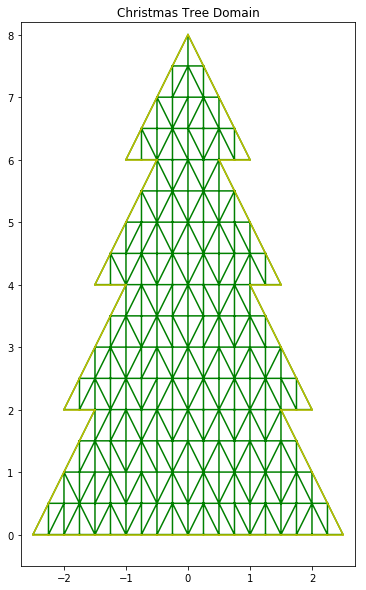

In [33]:
# Visualize the mesh
nodes, elements, boundary_nodes, boundary_edges = christmas_tree_mesh(2)

fig = plt.figure(figsize=(6,10))

plt.triplot(nodes[:,0], nodes[:,1], elements, color='g') # Triangles

# Boundary edges
for j, s in enumerate(boundary_edges):
    edge = nodes[s]
    plt.plot(edge[:,0], edge[:,1], 'y')

#for j, p in enumerate(nodes):
#    plt.text(p[0]-0.03, p[1]+0.03, j, color='r', ha='right') # label points

#for j, s in enumerate(elements):
#    p = nodes[s].mean(axis=0)
#    plt.text(p[0], p[1], '{}'.format(j), ha='center') # label triangles
    
#plt.plot(nodes[:,0], nodes[:,1], 'ro') # Nodes
#plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], 'yo', mfc='none') # Boundary nodes

plt.xlim(-2.7, 2.7); plt.ylim(-0.5, 8.2)
plt.title('Christmas Tree Domain')
plt.show()

## (a)

In [8]:
def assemble_stiffness_matrix_local(vertex_coords):
    ## Fill in
    a=vertex_coords[1]-vertex_coords[0]
    b=vertex_coords[2]-vertex_coords[0]
    det_B_T=np.absolute(a[0]*b[1]-a[1]*b[0])
    G_T=np.linalg.inv(np.array([[1,1,1],[vertex_coords[i,0] for i in [0,1,2]],[vertex_coords[i,1] for i in [0,1,2]]]))@np.array([[0,0],[1,0],[0,1]])
    
    return G_T@np.transpose(G_T)*0.5*det_B_T
    pass

def assemble_mass_matrix_local(vertex_coords):
    ## Fill in
    a=vertex_coords[1]-vertex_coords[0]
    b=vertex_coords[2]-vertex_coords[0]
    det_B_T=np.absolute(a[0]*b[1]-a[1]*b[0])
    
    return det_B_T*1./24*np.array([[2,1,1],[1,2,1],[1,1,2]])
    pass

def assemble_neumann_vector_local(vertex_coords):
    ## Fill in
    return np.linalg.norm(vertex_coords[0]-vertex_coords[1])*0.5


In [9]:
def assemble_stiffness_matrix(elements, nodes):
    # Empty sparse matrix 
    A = sp.lil_matrix((len(nodes), len(nodes)))
    
    # Loop over all elements 
    for idx in elements:
        A[tuple(np.meshgrid(idx, idx))] += assemble_stiffness_matrix_local(nodes[idx])
    
    return sp.csr_matrix(A)

def assemble_mass_matrix(elements, nodes):
    M = sp.lil_matrix((len(nodes),len(nodes)))
    
    for idx in elements:
        M[tuple(np.meshgrid(idx,idx))] += assemble_mass_matrix_local(nodes[idx])
        
    return sp.csr_matrix(M)

def assemble_neumann_vector(neumann_edges, nodes, neumann_fn):
    ## Fill in
    res=np.zeros(len(nodes))#need as many entries as nodes
    
    for edge in neumann_edges:
        edge_midpoint=.5*(nodes[edge[0]]+nodes[edge[1]])
        res[edge[0]]+=neumann_fn(edge_midpoint)*assemble_neumann_vector_local([nodes[edge[0]],nodes[edge[1]]])
        res[edge[1]]+=neumann_fn(edge_midpoint)*assemble_neumann_vector_local([nodes[edge[0]],nodes[edge[1]]])
        
    return res
        
        
    pass

## (b)

In [10]:
def solve(A, b, dirichlet_nodes, nodes, dirichlet_fn):
    ## Fill in
    res=np.zeros(len(nodes))
    for node_id in dirichlet_nodes:
        res[node_id]=dirichlet_fn(nodes[node_id])
    b-= A.dot(res) #danke für den Tipp
    #solve
    n=len(b)
    all_indices={i for i in range(n)}
    dirichlet_nodes=set(dirichlet_nodes) #turns the list into a set
    restr_indices= all_indices -dirichlet_nodes
    indices= sorted(list(restr_indices))
    
    A_restr = delete_from_csr(A, dirichlet_nodes, dirichlet_nodes)
    b_restr=np.array([b[i]for i in indices])
    restricted_res=spla.spsolve(A_restr,b_restr)
    
    for i in list(indices):
        res[i]+=restricted_res[0]
        restricted_res=restricted_res[1:]
        
    return res

    pass

## (c)

In [28]:
# Solve the discretized problem for k = 4
nodes, elements, boundary_nodes, boundary_edges = christmas_tree_mesh(6)

u_exact = lambda x: 0.6*x[1] + 0.5*x[0]**2 + np.cos(np.pi * x[1] / 2)
f = lambda x: (0.5*np.pi)**2 * np.cos(np.pi * x[1] / 2) - 1
g = lambda x: (0.6 + 2*abs(x[0]) - 0.5*np.pi*np.sin(np.pi * x[1] / 2)) / np.sqrt(5)

## Fill in

dirichlet_nodes=[node for node in boundary_nodes  if (nodes[node][1] in [0,2,4,6]) ]
neumann_edges=[edge for edge in boundary_edges if nodes[edge[0]][1]!= nodes[edge[1]][1]] #if y values are different, edge is non-horizontal
A=assemble_stiffness_matrix(elements,nodes)
M=assemble_mass_matrix(elements,nodes)
c=np.array([f(node) for node in nodes])
b=M.dot(c)+assemble_neumann_vector(neumann_edges,nodes, g)

u=solve(A, b, dirichlet_nodes, nodes, u_exact)






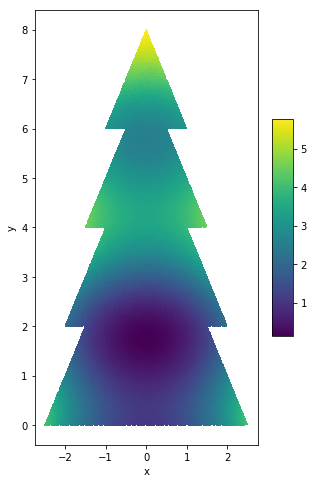

In [24]:
# Plot the previous solution

#plot
fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(111)

ax.set_xlabel('x')
ax.set_ylabel('y')
xy=nodes.ravel()

triang = tri.Triangulation(nodes[:,0], nodes[:,1], triangles=elements)
tripcolor=ax.tripcolor(triang, u.ravel())
fig.colorbar(tripcolor, shrink=0.5, aspect=10)
plt.show()

## (d)

In [29]:
def barycenter(triangle, nodes):
    return (nodes[triangle[0]]+nodes[triangle[1]]+nodes[triangle[2]])/3

def H1_error(elements, nodes, u, grad_u):
    res=0
    for element in elements:
        #print(element)?!
        a=nodes[element[1]]-nodes[element[0]]
        b=nodes[element[2]]-nodes[element[0]]
        area=np.absolute(a[0]*b[1]-a[1]*b[0])*.5
        G_T=np.linalg.inv(np.array([[1,1,1],[nodes[element[i],0] for i in [0,1,2]],[nodes[element[i],1] for i in [0,1,2]]]))@np.array([[0,0],[1,0],[0,1]])
        """
        Ich berechne den Gradienten mit
        G_T[0]*u[element[0]] +G_T[1]*u[element[1]] +G_T[2]*u[element[2]]
        also den gewichteten Gradienten der Hutfunktionen.
        Dass das jeweils die Zeilen von G_i sind habe ich aus den Folien vom Tutorium,
        aber da bin ich mir noch nicht sicher, da der Fehler noch recht groß ist (0,15 bei k=5)
        Die Rate scheint aber zu stimmen
        """
        res+= area*np.linalg.norm(G_T[0]*u[element[0]] +G_T[1]*u[element[1]] +G_T[2]*u[element[2]]-grad_u(barycenter(element, nodes)))
        
    return res
    
        
    pass
print(H1_error(elements,nodes,u,lambda x: np.array([x[0], 0.6 - 0.5*np.pi * np.sin(0.5*np.pi*x[1])])))

0.1583551884389896


## (e)

In [30]:
l2_errors = []
h1_errors = []
hs = []

grad_u = lambda x: np.array([x[0], 0.6 - 0.5*np.pi * np.sin(0.5*np.pi*x[1])])

for k in [2, 3, 4, 5]:
    nodes, elements, boundary_nodes, boundary_edges = christmas_tree_mesh(k)
    hs.append(np.sqrt(5)/(2**k))
    
    dirichlet_nodes=[node for node in boundary_nodes  if (nodes[node][1] in [0,2,4,6]) ]
    neumann_edges=[edge for edge in boundary_edges if nodes[edge[0]][1]!= nodes[edge[1]][1]] #if y values are different, edge is non-horizontal
    A=assemble_stiffness_matrix(elements,nodes)
    M=assemble_mass_matrix(elements,nodes)
    c=np.array([f(node) for node in nodes])
    b=M.dot(c)+assemble_neumann_vector(neumann_edges,nodes, g)

    u=solve(A, b, dirichlet_nodes, nodes, u_exact)
    
    h1_errors.append(H1_error(elements, nodes,u, grad_u))
    
    
    ## Fill in

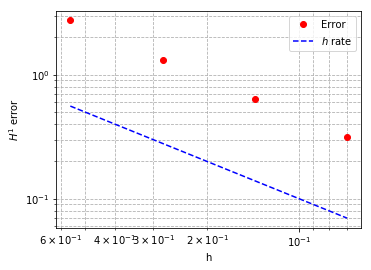

In [32]:
# Convergence of the (approximate) L^2 and H^1 errors

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

ax1.set_xlabel('h')
ax1.set_ylabel(r'$H^1$' + ' error')
ax1.invert_xaxis()

ax1.loglog(hs, h1_errors, 'ro', label='Error')
ax1.loglog(hs, [h for h in hs], 'b--', label=r'$h$' + ' rate')
ax1.grid(True, which="both", ls="--")
ax1.legend()
plt.show()